**Pooya Kabiri - 96521434**


Importing prerequisites:

In [25]:
import cv2
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import os

%tensorflow_version 2.x
from keras.datasets import fashion_mnist
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Activation
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from keras.utils.vis_utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.model_selection import train_test_split

Plotter Cell.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

**I changed** the evaluation method to work with arrays of shape (N, 1) instead of using array-like objects of shape (N,). To achieve this I used `tensorflow.math.confusion_matrix` method instead of `sklearn.metrics.confusion_matrix`.

In [3]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and F1-score and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for', title, '=', acc)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    print('F1 score for', title, '=', f1)
    cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=10)
    cm = np.array(cm)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

**Here** I check for existence of **Tensor Processing Unit (TPU)** to. accelerate my trining proedure significantly.

**If** the TPU exists in the virtual machine environment, the vm is connected to the TPU System and the TPU System is initialized.

**Then** a training strategy is created for the use of cpu on training of a Tensorflow.Keras model. Models created under this strategy's scope can benefit from a Distributed TPU Training procedur.

In [4]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.4.0
Running on TPU  ['10.126.195.10:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.126.195.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.195.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Here** the hyper-parameters for the model is defined.

In [5]:
HEIGHT, WIDTH, CH, N_CLASSES = 28, 28, 1, 10
BATCH_SIZE = 2048
EPOCHS = 50
REPEAT = 2

**Loading** the data set and splitting it into train and test sets.

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


**Creating** a backup version of the test sets before doing any preprocessing, these sets are used further in the notebook for visualization perposes.

In [7]:
x_test_visual = x_test
y_test_visual = y_test

**First,** the data sets are reshaped to avoid array-like shapes: (N,).

**Seocond,** the y data sets are transformed into a one hot shape using `keras.utils.to_categorical`.

**Third,** the x data sets are transformed into a 28x28x1 shape for havinf a valid single channel.

**Lastly,** the image dataas are normalized between values of 0 and 1 for a better performance during training and less biased training process.

In [8]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = keras.utils.to_categorical(y_train, N_CLASSES)
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


**Dev** data set (also called cross-validation set) is created by using a ratio (0.2) of the training data. This split is performed with `sklearn.model_selection.train_test_split` method. Also this method shuffles the sets for less biased training.

In [9]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_dev.shape, y_dev.shape)

(48000, 28, 28, 1) (48000, 10) (10000, 28, 28, 1) (10000, 10) (12000, 28, 28, 1) (12000, 10)


**Because** using a tpu system for training, the speed of propagating a. atch through the model is very high that the model can halt on receiving data (speed of feeding the data to the model is lower than the training speed), so in this case I used a `Tensorflow.data.Dataset` API for creating a data  pipeline which can feed the TPU system seamlessly.

In [10]:
### Creating the Dataset object with numpy arrays of x_train and y_train
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

### Shuffling the Dataset object with buffer size of 3 and reshuffling it for every epoch
train_dataset = train_dataset.shuffle(3, reshuffle_each_iteration=True)

### Repeating the dataset in each epoch for number of REPEAT times
train_dataset = train_dataset.repeat(REPEAT)

### Batching the data
train_dataset = train_dataset.batch(BATCH_SIZE)

### Enabling the prefetching of every brach before the batch is fed to the TPU system
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Printing Dataset overview
print(train_dataset)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>


In [11]:
### Creating the Dataset object with numpy arrays of x_dev and y_dev
dev_dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))

### Shuffling the Dataset object with buffer size of 3 and reshuffling it for every epoch
dev_dataset = dev_dataset.shuffle(3, reshuffle_each_iteration=True)

### Repeating the dataset in each epoch for number of REPEAT times
dev_dataset = dev_dataset.repeat(REPEAT)

### Batching the data
dev_dataset = dev_dataset.batch(BATCH_SIZE)

### Enabling the prefetching of every brach before the batch is fed to the TPU system
dev_dataset = dev_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Printing Dataset overview
print(dev_dataset)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>


In [12]:
### Creating the Dataset object with numpy arrays of x_test and y_test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

### Batching the data
test_dataset = test_dataset.batch(BATCH_SIZE)


### Enabling the prefetching of every brach before the batch is fed to the TPU system
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Printing Dataset overview
print(test_dataset)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>


**Implementation** of the `InceptionV3` neural block. This block is further used in creating the model.

In [13]:
def InceptionBlock(X):

    Tower1 = Conv2D(64, (1,1), padding='same')(X)
    Tower1 = Activation('relu')(Tower1)
    
    Tower2 = Conv2D(64, (1,1), padding='same')(X)
    Tower2 = Activation('relu')(Tower2)
    Tower2 = Conv2D(64, (3,3), padding='same')(Tower2)
    Tower2 = Activation('relu')(Tower2)

    Tower3 = Conv2D(64, (1,1), padding='same')(X)
    Tower3 = Activation('relu')(Tower3)
    Tower3 = Conv2D(64, (5,5), padding='same')(Tower3)
    Tower3 = Activation('relu')(Tower3)

    Tower4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(X)
    Tower4 = Conv2D(64, (1,1), padding='same')(Tower4)
    Tower4 = Activation('relu')(Tower4)

    Out = Concatenate(axis = 3)([Tower1, Tower2, Tower3, Tower4])

    return Out


**Creating** the Convolutional Neural Network (CNN) model.

The architecture of the model: 

1.   1 Input Layer
1.   Batch Normalization Layer
2.   3 InceptionBlocks with a Batch Normalization Layer after each
2.   1 Flatten Layer
2.   Dense Layer with 1024 neurons and ReLU Activation
2.   Dense Layer with 512 neurons and ReLU Activation
2.   Dense Layer with 128 neurons and ReLU Activation
2.   Dense Layer with N_CLASSES (10) neurons and Softmax Activation

**This Model** is created using the `tensorflow.keras.model` and by using the `Model Functional API` (not `Model Sequential API`).

In [14]:
def create_model():

    input = keras.Input(shape=(HEIGHT , WIDTH, CH))

    X = BatchNormalization()(input)

    X = InceptionBlock(X)
    X = BatchNormalization()(X)

    X = InceptionBlock(X)
    X = BatchNormalization()(X)

    X = InceptionBlock(X)
    X = BatchNormalization()(X)

    X = InceptionBlock(X)
    X = BatchNormalization()(X)

    X = Flatten()(X)

    X = Dense(1024)(X)
    X = Activation('relu')(X)
        
    X = Dense(512)(X)
    X = Activation('relu')(X)
        
    X = Dense(128)(X)
    X = Activation('relu')(X)

    X = Dense(N_CLASSES)(X)

    X = Activation('softmax')(X)

    model = Model(input, X)
    model.summary()

    return model

**Here** a model is created by calling the `create_model` method. 

**Then** the model in compiled with an Adam default optimizer and Categorical Crossentropy loss.

**Note** that the model creation and compilation are under the TPU Strategy Scope for distributed training.



In [15]:
with tpu_strategy.scope():

    model = create_model()
    model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['categorical_accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   128         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   128         batch_normalization[0][0]        
______________________________________________________________________________________________

**Plotting** the model architecture.

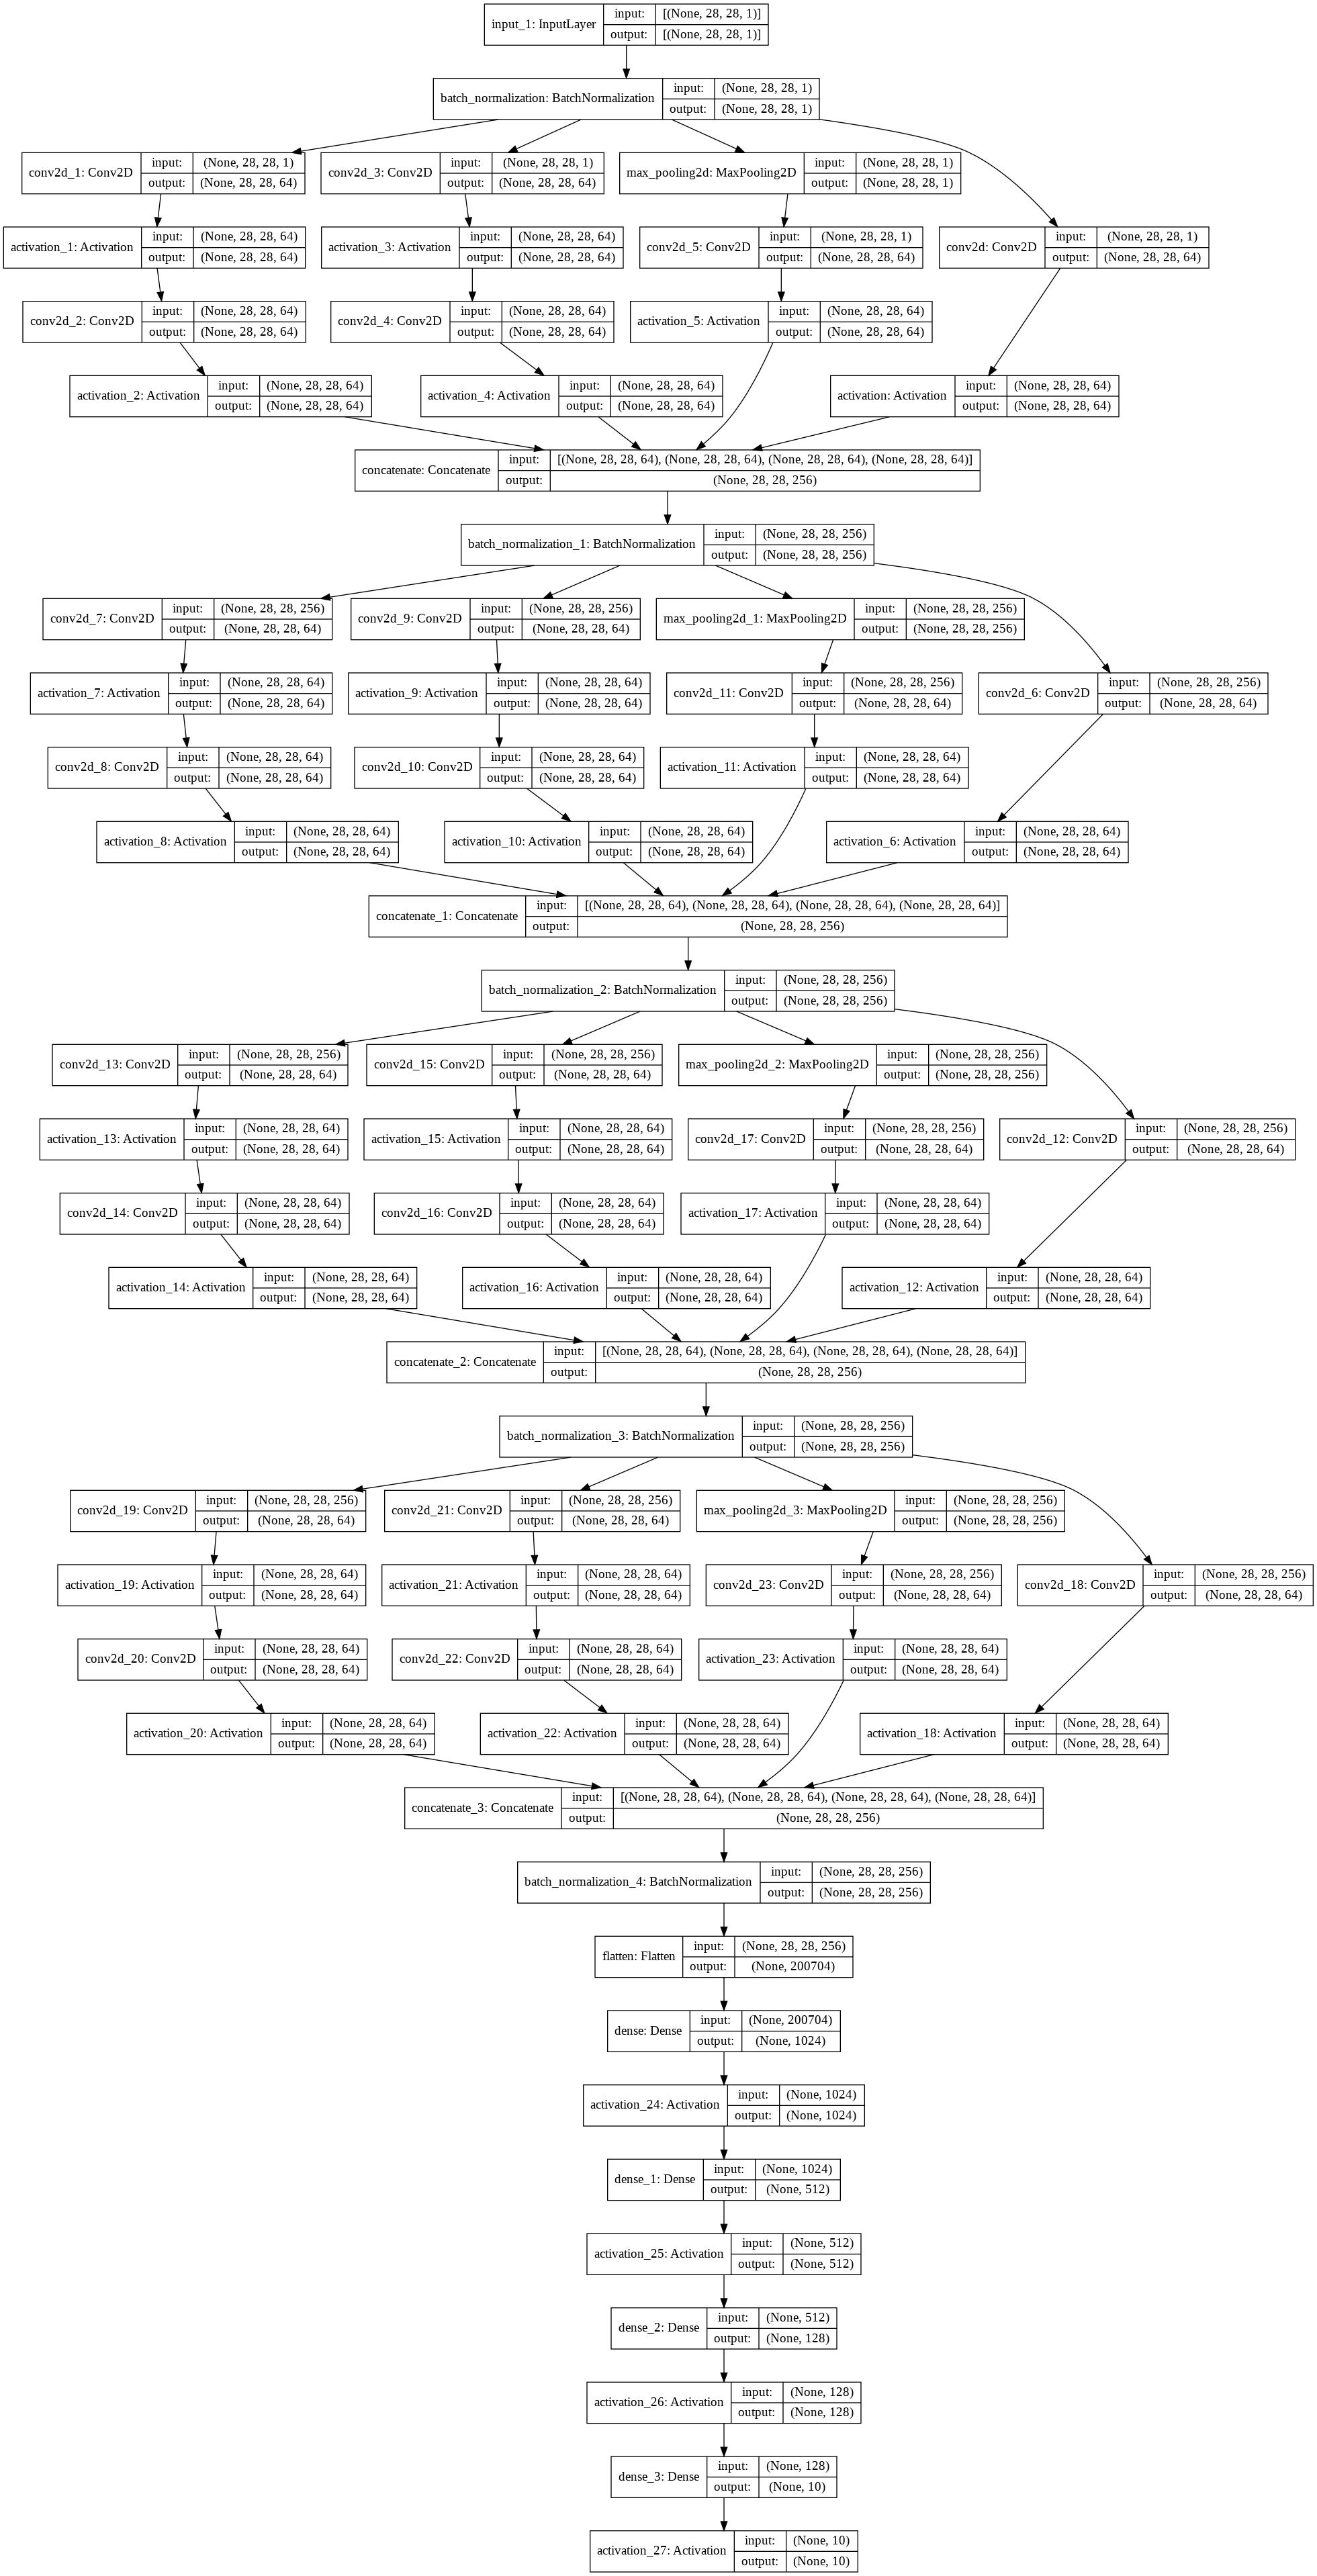

In [16]:
tf.keras.utils.plot_model(model, to_file='model_arch.png', show_shapes=True)

**Finally,** the model is trained on the training data set for EPOCH (100)number of epochs, and uses dev data set for cross validation check to prevent overfitting the training data.

In [17]:
history = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=dev_dataset)

Epoch 1/50
47/47 [==============================] - 46s 560ms/step - loss: 9.6613 - categorical_accuracy: 0.5517 - val_loss: 3.1893 - val_categorical_accuracy: 0.0935
Epoch 2/50
47/47 [==============================] - 13s 281ms/step - loss: 0.2660 - categorical_accuracy: 0.9034 - val_loss: 4.0742 - val_categorical_accuracy: 0.1721
Epoch 3/50
47/47 [==============================] - 13s 284ms/step - loss: 0.1639 - categorical_accuracy: 0.9419 - val_loss: 4.8040 - val_categorical_accuracy: 0.2380
Epoch 4/50
47/47 [==============================] - 13s 280ms/step - loss: 0.1215 - categorical_accuracy: 0.9572 - val_loss: 5.7731 - val_categorical_accuracy: 0.1700
Epoch 5/50
47/47 [==============================] - 13s 278ms/step - loss: 0.1058 - categorical_accuracy: 0.9622 - val_loss: 5.7208 - val_categorical_accuracy: 0.1932
Epoch 6/50
47/47 [==============================] - 13s 279ms/step - loss: 0.0693 - categorical_accuracy: 0.9765 - val_loss: 4.3555 - val_categorical_accuracy: 0.316

**Now** ther model performance is evaluated.

**As seen,** the model is able to pull up a accuracy score above %90 on the test set.

In [63]:
loss, accuracy = model.evaluate(test_dataset, verbose=0)

In [64]:
print('Test loss:', loss)
print('Test accuracy:', accuracy * 100)

Test loss: 0.46180495619773865
Test accuracy: 92.30999946594238


**Here** we get predcition probabilities by calling the `model.predict` method.

**Then** the prediction values are transformed into prediction labels using the `numpy.argmax` method.

**Thirdly,** a prediction mask is created for further use by one-hot coding of the prediction labels. This is achieved by using `keras.utils.to_categorical`.

In [65]:
prediction_probs = model.predict(test_dataset)
prediction_labels = np.argmax(prediction_probs, axis=1).reshape(-1, 1)

**Evaluating** the model by **accuracy**, **F1 score** and **Confusion Matrix**.

Accuracy for Confusion Matrix = 0.9231
F1 score for Confusion Matrix = 0.9230200121092225


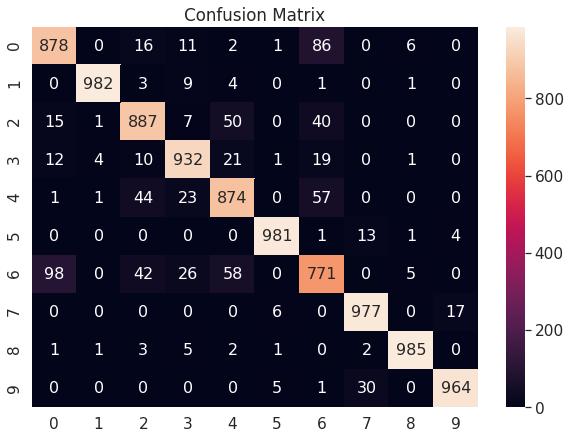

In [66]:
evaluation(y_test_visual, prediction_labels, 'confusion_matrix', 'Confusion Matrix')

**Here** the 10 most **BAD BOIS** (10 most inaccurate predictions) of model predictions on the test data set is computed and plotted.

In [67]:
prediction_mask = keras.utils.to_categorical(prediction_labels, N_CLASSES)
bad_loss_mask = np.logical_or(np.logical_not(y_test), prediction_mask)
masked_predictions = ma.masked_array(prediction_probs, mask=bad_loss_mask)

In [68]:
min_probs = masked_predictions.min(axis=1).data.reshape(1, -1)
indices = np.argsort(min_probs)[0, :12]

In [69]:
images_array = x_test_visual[indices]
true_labels = y_test_visual[indices].flatten()
false_labels = prediction_labels[indices].flatten()

In [70]:
images = []
for i in range(images_array.shape[0]):
    text = "P: " + str(false_labels[i]) + ", T: " + str(true_labels[i])
    images.append([images_array[i, :, :], text, 'img'])

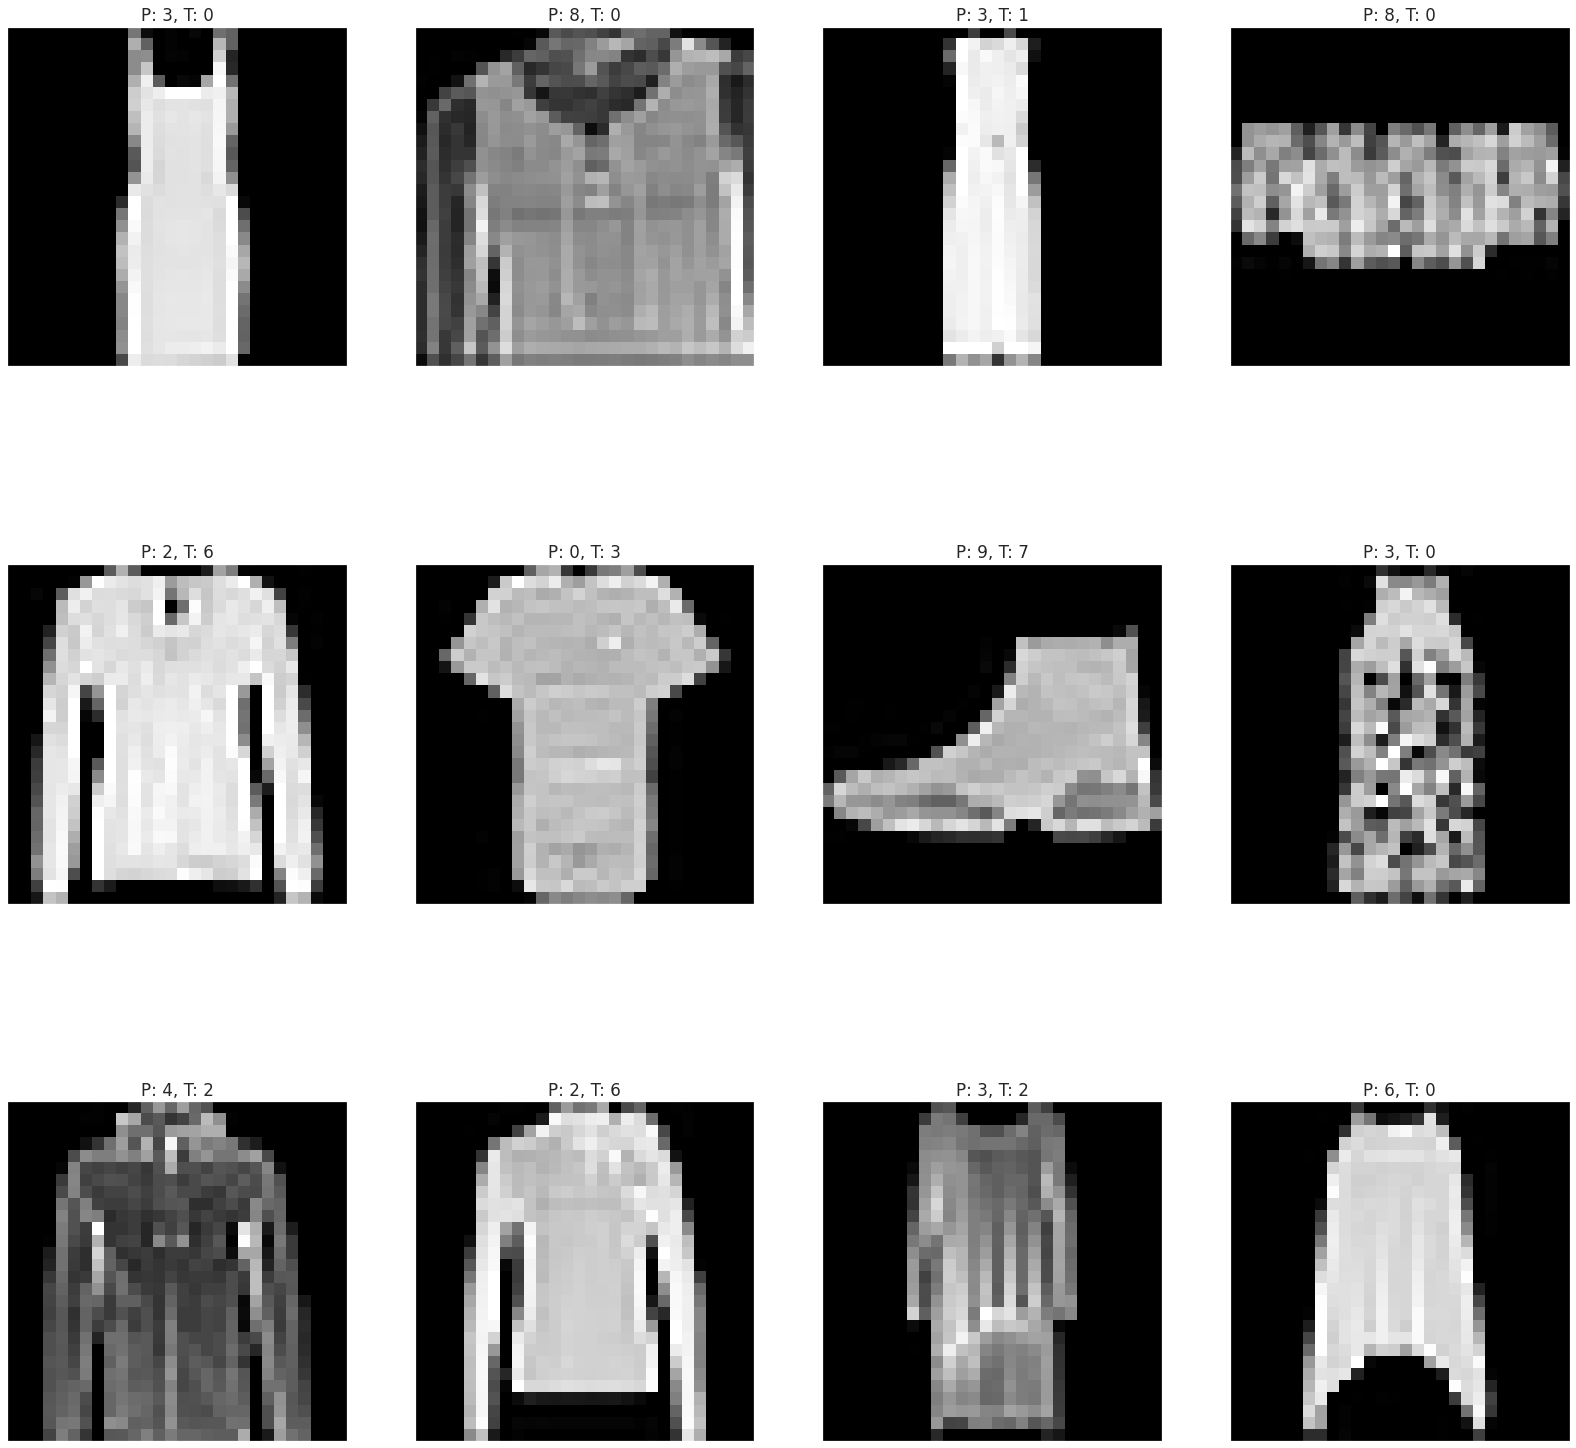

In [71]:
plotter(images, 3, 4, True, 28, 28, 'Bad Bois')